<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from numpy import asarray
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from keras.preprocessing import image
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v3 import MobileNetV3

drive.mount('/content/drive')

Mounted at /content/drive


#Import data

In [4]:
train_dir = "/content/drive/MyDrive/Pneumonia/train/"
test_dir = "/content/drive/MyDrive/Pneumonia/test/"
val_dir = "/content/drive/MyDrive/Pneumonia/val/"

#images to 3d-array 
def img_to_array(dir, label, img_size = 128): 
  image_path = dir + str(label.upper()) #folder name is in upper case 
  image_files = os.listdir(os.path.join(dir, str(label.upper())))
  
  #converting pneumonia/normal images to array 
  images = []
  b_images, v_images = [], [] 
  for image_file in tqdm(image_files): 
    image = cv2.imread(os.path.join(image_path, image_file))
    image = cv2.resize(image, (img_size, img_size)) 
    image = image / 255. 
    images.append(image)

    if label == 'pneumonia': 
      if image_file.split('_')[1] == 'bacteria': 
        b_images.append(image)
      elif image_file.split('_')[1] == 'virus': 
        v_images.append(image)
    
  if label == 'normal': 
    return np.array(images)
  
  elif label == 'pneumonia': 
    return np.array(images), np.array(b_images), np.array(v_images)

In [5]:
#convert train images to 3d arrays 
print("===========training set===========")
p_train, b_train, v_train = img_to_array(train_dir, 'pneumonia')
n_train = img_to_array(train_dir, 'normal')
print("normal: ", n_train.shape, "pneumonia:",p_train.shape, "bateria:", b_train.shape, "virus:",v_train.shape)

#convert validation images to 3d arrays 
print("===========validation set===========")
p_val, b_val, v_val = img_to_array(val_dir, 'pneumonia')
n_val = img_to_array(val_dir, 'normal')
print("normal: ", n_val.shape, "pneumonia:",p_val.shape, "bateria:", b_val.shape, "virus:",v_val.shape)

#convert test images to 3d arrays 
print("===========test set===========")
p_test, b_test, v_test = img_to_array(test_dir, 'pneumonia')
n_test = img_to_array(test_dir, 'normal')
print("normal: ", n_test.shape, "pneumonia:",p_test.shape, "bateria:", b_test.shape, "virus:", v_test.shape)

===========training set===========


100%|██████████| 1359/1359 [01:03<00:00, 21.27it/s]


normal:  (1359, 128, 128, 3) pneumonia: (3933, 128, 128, 3) bateria: (2561, 128, 128, 3) virus: (1372, 128, 128, 3)
===========validation set===========


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


normal:  (8, 128, 128, 3) pneumonia: (8, 128, 128, 3) bateria: (8, 128, 128, 3) virus: (0,)
===========test set===========


100%|██████████| 234/234 [00:07<00:00, 29.48it/s]

normal:  (234, 128, 128, 3) pneumonia: (390, 128, 128, 3) bateria: (242, 128, 128, 3) virus: (148, 128, 128, 3)


#EDA

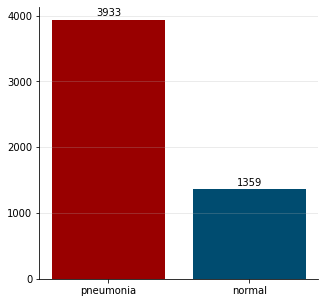

In [10]:
num_pneumonia = len(p_train)
num_normal = len(n_train)

#bar-chart pneumonia vs normal 
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [num_pneumonia, num_normal], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')
  
# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)

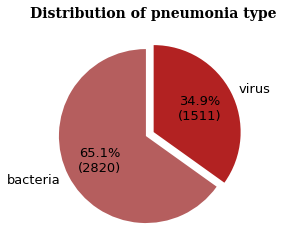

In [7]:
y = [len(b_train), len(v_train)]
labels = ["bacteria", "virus"]
colors = ['#b55e5e','#b22222']
myexplode = [0.1, 0]
def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * 4331) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

In [42]:
#@title show_images function
#sample images from each class
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 

  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]))
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)


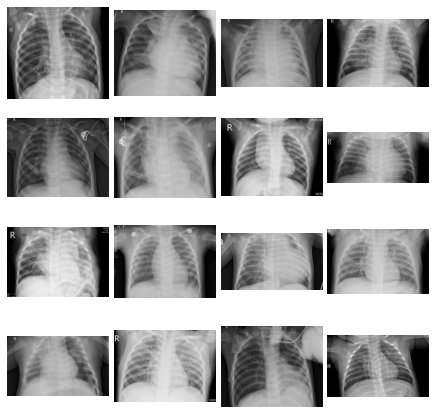

In [44]:
show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

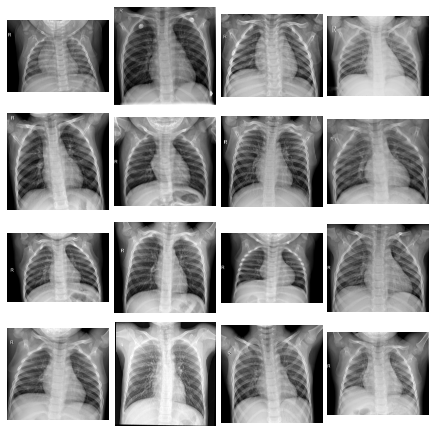

In [12]:
show_images(train_dir, label="NORMAL", size=4)

### Average image

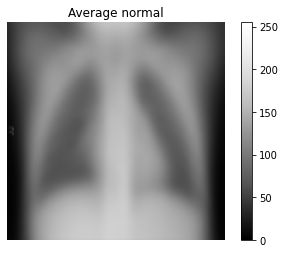

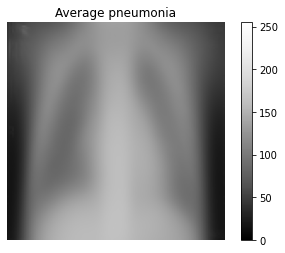

In [34]:
#@title

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def average_img(images_list, label, size = (128,128,3)):
    # calculate the average
    avg_img = np.mean(images_list, axis = 0)
    # reshape
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='Greys_r', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()}')
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return rgb2gray(avg_img)

norm_mean = average_img(n_train, 'NORMAL')
pneu_mean = average_img(p_train, 'PNEUMONIA')
#pneumonia X-rays tend to show higher obstruction around the chest area.

###Contrast

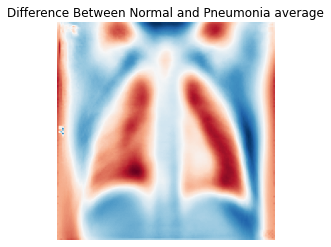

In [36]:
#@title
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='RdBu')
plt.title(f'Difference Between Normal and Pneumonia average')
plt.axis('off')
plt.show()
#red indicates the most different areas in dark color 
#blue indicates the most different areas in light color 

### standard deviation 

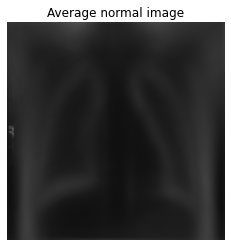

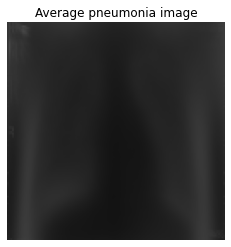

In [41]:
#@title
def std_img(images_list, label, size = (128,128,3)):
    # calculate the average
    avg_img = np.std(images_list, axis = 0)
    # reshape it back to a matrix
    avg_img = avg_img.reshape(size)
    plt.imshow(avg_img, cmap='gray', vmin=0, vmax=255) 
    plt.title(f'Average {label.lower()} image')
    plt.axis('off')
    plt.show()
    return avg_img

norm_std = std_img(n_train, 'NORMAL')
pneu_std = std_img(p_train, 'PNEUMONIA')

#there are larger areas of variance found in pneumonia lung 

#Image preprocessing

In [51]:
img_size = 128
batch_size = 32
epoch_size = 15

train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

test_datagen = ImageDataGenerator()


### Augmented Data

In [52]:
#normal vs pneumonia 
x_train = np.concatenate((p_train, n_train))
y_train = np.concatenate((np.ones(len(p_train)), np.zeros(len(n_train)))) #label [0,1] == [normal, pneumonia]
x_val = np.concatenate((p_val, n_val))
y_val = np.concatenate((np.ones(len(p_val)), np.zeros(len(n_val))))
x_test = np.concatenate((p_test, n_test))
y_test = np.concatenate((np.ones(len(p_test)), np.zeros(len(n_test)))) 

aug_train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

### Balanced Augmented Data

In [53]:
#balanced augmented data 
#current image dataset is an imbalanced dataset approx. ratio is 3:1 (pneumonia: normal)
#to balance out the data, I applied oversampling which will increase the size of normal images as the size of pneumonia 

#flatten three channels of each image to one array 
reshaped_x_train = x_train.reshape(x_train.shape[0],-1) 

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_x_train , y_train)

# reshaping X back to the first dims
oversampled_X = oversampled_X.reshape(-1,img_size,img_size,3)

print("imbalanced x_train had {} pneumonia and {} normal samples".format(len(p_train), len(n_train)))
print("balanced set now has {} pneumonia and {} normal samples".format(int(sum(oversampled_y)), int(len(oversampled_X) - sum(oversampled_y))))

balanced_train_generator = train_datagen.flow(oversampled_X, oversampled_y, batch_size=batch_size)

imbalanced x_train had 3933 pneumonia and 1359 normal samples
balanced set now has 3933 pneumonia and 3933 normal samples


### Non-augmented Data

In [54]:
raw_train_generator = test_datagen.flow(x_train, y_train, batch_size=batch_size)

In [90]:
val_generator = test_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=len(x_test), shuffle=False)

##Augmented image sample 

class:  PNEUMONIA


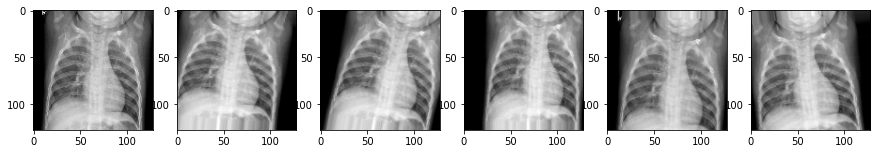

In [56]:
#augmentation of a sample in the training set 
labels =  ['NORMAL','PNEUMONIA']
fig, axes = plt.subplots(1,6,figsize=(15,15))
orig_img = np.array([x_train[0]]) #first image in the training set (original: non-augmented)
axes[0].imshow(orig_img.reshape(img_size,img_size,3), cmap='gray') 
for i in range(5): #display five generated augmented images
  sample, label = train_datagen.flow(orig_img, y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')
print("class: ", labels[int(label[0])])

#CNN Modeling

In [115]:
#@title create_plot
def create_plot(model, history, epoch_size): 
    epochs = [i for i in range(epoch_size)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(12,6)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Accuracy & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
    #evaluation metric
    metrics(model)

In [58]:
#@title create_model and lr reduction callback
def create_model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.3, min_lr=0.000001)

In [113]:
#@title evaluation_metrics
def metrics(model): 
    test_generator.reset()
    labels = ['NORMAL', 'PNEUMONIA']
    pred = model.predict_generator(test_generator,steps=len(test_generator),verbose=1)
    ypred = np.round(pred)
    _, ytrue = test_generator.next()
    print(classification_report(ytrue, ypred, target_names=labels))
    
    conf_mat = confusion_matrix(ytrue, ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')


###with augmented training set


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
1/1 [==============================] - 0s 240ms/step - loss: 0.3262 - accuracy: 0.9119
Test loss:  0.3261517286300659
Test accuracy 0.9118589758872986


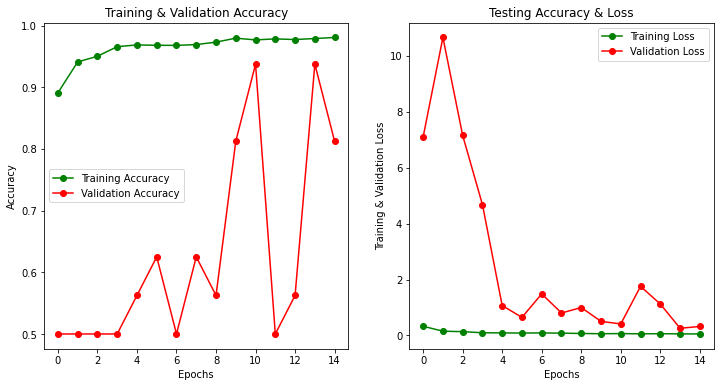

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 271ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.80      0.87       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



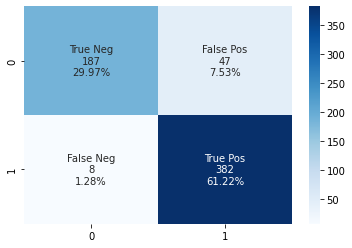

In [116]:
model = create_model()
history = model.fit(aug_train_generator, epochs=epoch_size, validation_data=val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model, history, epoch_size)

###with balanced and augmented training set


Epoch 5: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 [==============================] - 1s 554ms/step - loss: 0.6867 - accuracy: 0.6250
Test loss:  0.6866955161094666
Test accuracy 0.625


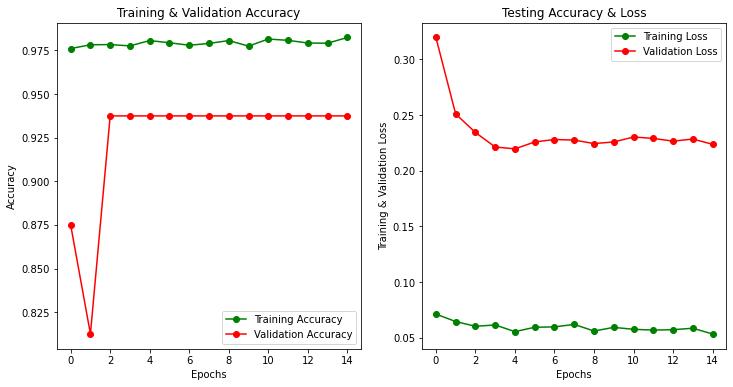

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 265ms/step
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


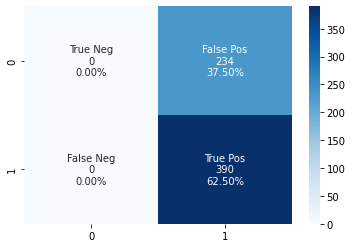

In [117]:
model2 = create_model()
history = model.fit(balanced_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model2.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model2, history, epoch_size)

###without augmentation (raw training set)


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
1/1 [==============================] - ETA: 0s - loss: 1.9922 - accuracy: 0.7388Test loss:  1.992221713066101
Test accuracy 0.7387820482254028


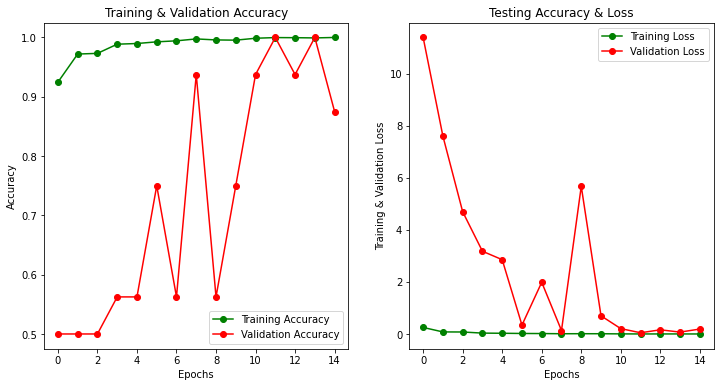

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 280ms/step
              precision    recall  f1-score   support

      NORMAL       0.97      0.31      0.47       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.65       624
weighted avg       0.81      0.74      0.69       624



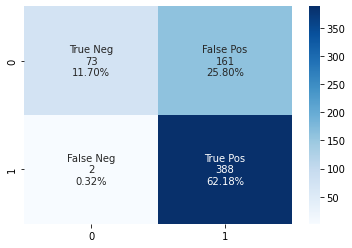

In [104]:
model3 = create_model()
history = model.fit(raw_train_generator, epochs = epoch_size , validation_data = val_generator, callbacks = [learning_rate_reduction], verbose=0)
score = model3.evaluate(test_generator)
print("Test loss: " , score[0])
print("Test accuracy" , score[1])

create_plot(model3, history, epoch_size)

#Transfer learning

1.   ResNet50
2.   DenseNet121
3. VGG16
4. InceptionV3
5. Xception

In [106]:
#@title create_pretrained
def create_pretrained(base_model):
  inputs = base_model.input
  x = base_model.output
  x = Dense(128, activation='relu')(x)
  outputs = Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model 

###ResNet50
0.9471
0.9407
0.7724

94781440/94765736 [==============================] - 0s 0us/step

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
1/1 [==============================] - 6s 6s/step - loss: 0.2588 - accuracy: 0.9343


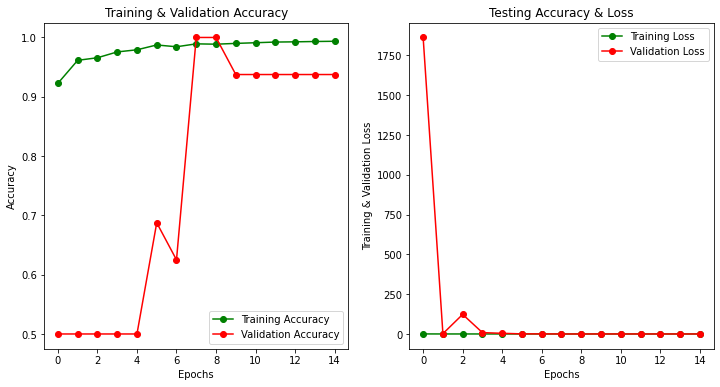

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 164ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.86      0.91       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



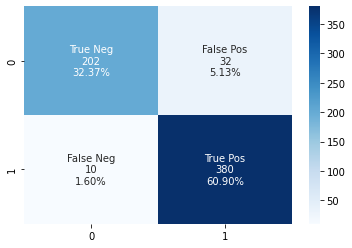

In [107]:
#with augmented training set 
resnet50 = ResNet50(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
resnet50 = create_pretrained(resnet50)
resnet50_history = resnet50.fit(aug_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=0, callbacks=[learning_rate_reduction])
resnet50.evaluate(test_generator)
create_plot(resnet50, resnet50_history, epoch_size)


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 [==============================] - 1s 783ms/step - loss: 0.1559 - accuracy: 0.9567


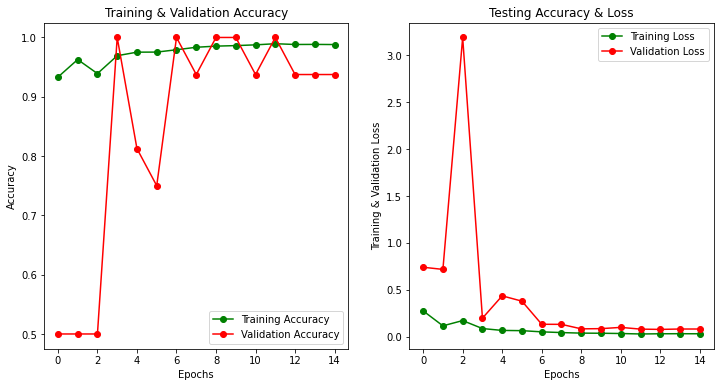

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 168ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.86      0.91       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



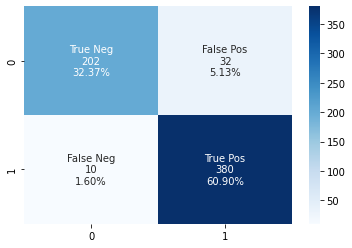

In [108]:
#with balanced augmented training set 
resnet50 = ResNet50(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
resnet50 = create_pretrained(resnet50)
resnet50_history = resnet50.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=0, callbacks=[learning_rate_reduction])
resnet50.evaluate(test_generator)
create_plot(resnet50, resnet50_history, epoch_size)


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
1/1 [==============================] - 1s 781ms/step - loss: 2.1777 - accuracy: 0.7949


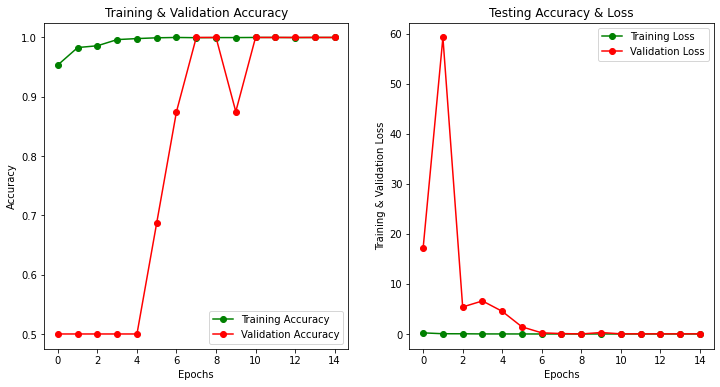

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 163ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.86      0.91       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



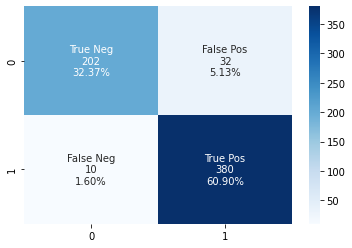

In [109]:
#without augmentation 
resnet50 = ResNet50(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
resnet50 = create_pretrained(resnet50)
resnet50_history = resnet50.fit(raw_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=0, callbacks=[learning_rate_reduction])
resnet50.evaluate(test_generator)
create_plot(resnet50, resnet50_history, epoch_size)

###DenseNet121
0.9551
0.9535
0.8077

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/15
166/166 [==============================] - 42s 167ms/step - loss: 0.2295 - accuracy: 0.9238 - val_loss: 0.7698 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/15
166/166 [==============================] - 23s 138ms/step - loss: 0.0953 - accuracy: 0.9649 - val_loss: 3.2678 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/15
166/166 [==============================] - 23s 137ms/step - loss: 0.0802 - accuracy: 0.9711 - val_loss: 0.5232 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/15
166/166 [==============================] - 23s 136ms/step - loss: 0.0763 - accuracy: 0.9715 - val_loss: 0.2392 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/15
166/166 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9743
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 23s 137ms/step - loss: 0.0669 - accuracy: 0.9743 - val_loss: 0.7118 - val_accuracy: 0.62

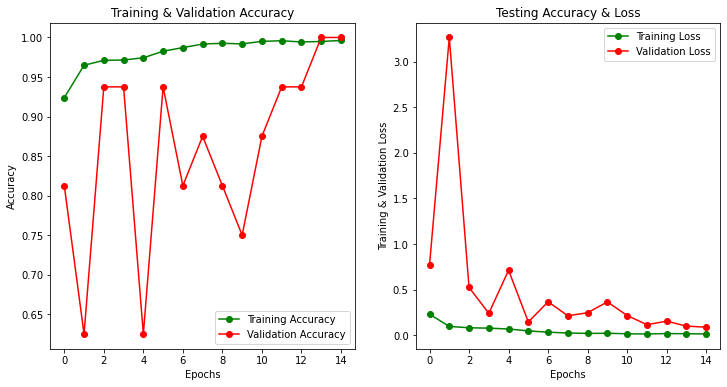

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 157ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.86      0.91       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



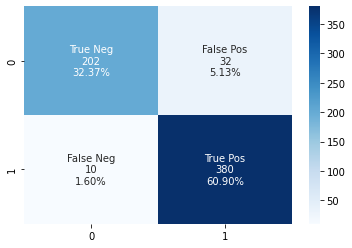

In [110]:
#with augmented training set 
densenet121 = DenseNet121(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
densenet121 = create_pretrained(densenet121)
densenet121_history = densenet121.fit(aug_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
densenet121.evaluate(test_generator)
create_plot(densenet121, densenet121_history, epoch_size)

Epoch 1/15
246/246 [==============================] - 49s 156ms/step - loss: 0.1690 - accuracy: 0.9448 - val_loss: 0.8130 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/15
246/246 [==============================] - 34s 137ms/step - loss: 0.0815 - accuracy: 0.9722 - val_loss: 0.2643 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/15
246/246 [==============================] - 34s 136ms/step - loss: 0.0707 - accuracy: 0.9752 - val_loss: 0.6005 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/15
246/246 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9789
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
246/246 [==============================] - 34s 137ms/step - loss: 0.0596 - accuracy: 0.9789 - val_loss: 1.4026 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/15
246/246 [==============================] - 34s 137ms/step - loss: 0.0343 - accuracy: 0.9882 - val_loss: 0.0770 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 6/15
246/246 [=========================

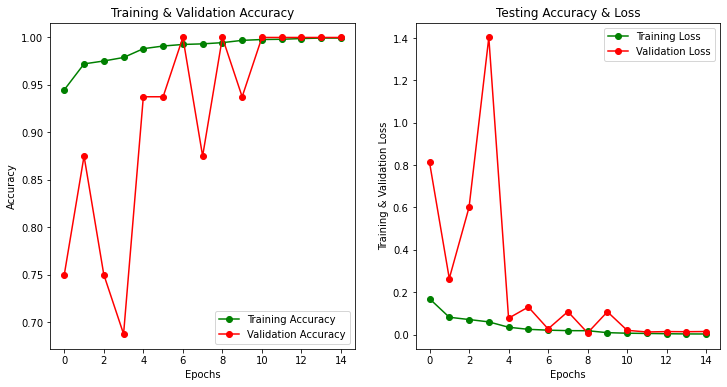

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


1/1 [==============================] - 0s 140ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.86      0.91       234
   PNEUMONIA       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624



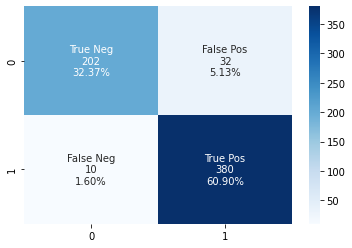

In [111]:
#with balanced augmented training set
densenet121 = DenseNet121(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
densenet121 = create_pretrained(densenet121)
densenet121_history = densenet121.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
densenet121.evaluate(test_generator)
create_plot(densenet121, densenet121_history, epoch_size)

In [ ]:
#without augmentation 
densenet121 = DenseNet121(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
densenet121 = create_pretrained(densenet121)
densenet121_history = densenet121.fit(raw_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
densenet121.evaluate(test_generator)
create_plot(densenet121, densenet121_history, epoch_size)

###VGG16
0.8542
0.9006
0.7212

In [ ]:
#with augmented training set 
vgg16 = VGG16(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
vgg16 = create_pretrained(vgg16)
vgg16_history = vgg16.fit(aug_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
vgg16.evaluate(test_generator)
create_plot(vgg16, vgg16_history, epoch_size)

In [ ]:
#with balanced augmented training set
vgg16 = VGG16(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
vgg16 = create_pretrained(vgg16)
vgg16_history = vgg16.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
vgg16.evaluate(test_generator)
create_plot(vgg16, vgg16_history, epoch_size)

In [ ]:
#without augmentation 
vgg16 = VGG16(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
vgg16 = create_pretrained(vgg16)
vgg16_history = vgg16.fit(raw_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
vgg16.evaluate(test_generator)
create_plot(vgg16, vgg16_history, epoch_size)

###Inception-V3
0.9247
0.9519
0.7628

In [ ]:
#with augmented training set 
inception = InceptionV3(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
inception = create_pretrained(inception)
inception_history = inception.fit(aug_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
inception.evaluate(test_generator)
create_plot(inception, inception_history, epoch_size)

In [ ]:
#with balanced augmented training set
inception = InceptionV3(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
inception = create_pretrained(inception)
inception_history = inception.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
inception.evaluate(test_generator)
create_plot(inception, inception_history, epoch_size)

In [ ]:
#without augmentation 
inception = InceptionV3(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
inception = create_pretrained(inception)
inception_history = inception.fit(raw_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
inception.evaluate(test_generator)
create_plot(inception, inception_history, epoch_size)

###XCeption
0.9455
0.9551
0.7837

In [ ]:
#with augmented training set 
xception = Xception(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
xception = create_pretrained(xception)
xception_history = xception.fit(aug_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
xception.evaluate(test_generator)
create_plot(xception, xception_history, epoch_size)

In [ ]:
#with balanced augmented training set
xception = Xception(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
xception = create_pretrained(xception)
xception_history = xception.fit(balanced_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
xception.evaluate(test_generator)
create_plot(xception, xception_history, epoch_size)

In [ ]:
#without augmentation 
xception = Xception(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet', pooling='max')
xception = create_pretrained(xception)
xception_history = xception.fit(raw_train_generator, validation_data=val_generator, epochs=epoch_size, verbose=1, callbacks=[learning_rate_reduction])
xception.evaluate(test_generator)
create_plot(xception, xception_history, epoch_size)

#Visualization of activation layers